# Modeling AD Severity Score Dynamics

### This model is taken from the paper "Personalized prediction of daily eczema severity scores using a mechanistic machine learning model" - Hurault G.


This notebook models the dynamics of the AD severity score based on the autoregressive process and flare triggers. We will model the parameters: 

- $\alpha^{(k)}$: Autocorrelation for patient $ k $
- $\theta^{(k)}$: Responsiveness to treatment for patient $ k $
- $P^{(k)}$: Flare trigger rate for patient $ k $

Finally, we will simulate the model dynamics that describe the temporal progression of the severity score.

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, truncnorm

### Sample Patient-Specific Parameters

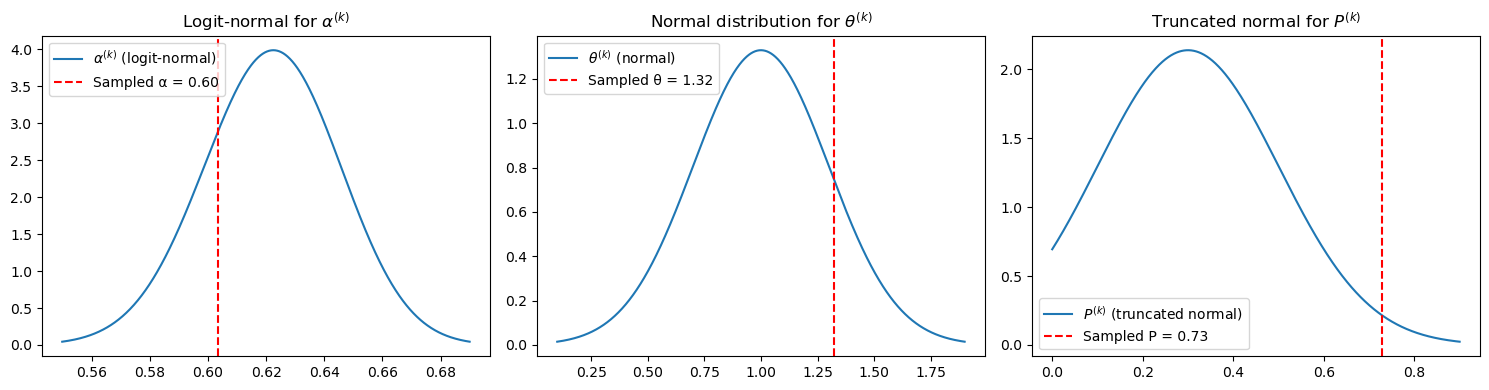

Sampled α = 0.60, θ = 1.32, P = 0.73


In [3]:
# Define population mean and variance for each parameter
mu_alpha, sigma_alpha = 0.5, 0.1  # Mean and std-dev for alpha in logit-normal
mu_theta, sigma_theta = 1.0, 0.3  # Mean and std-dev for theta in normal
mu_P, sigma_P = 0.3, 0.2          # Mean and std-dev for P in truncated normal

# Sampling and distribution visualization for alpha_k, theta_k, and P_k
def plot_distributions():
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # 1. Logit-normal distribution for alpha_k
    # Generate a range of samples for a logit-normal distribution
    u_samples = np.linspace(mu_alpha - 3 * sigma_alpha, mu_alpha + 3 * sigma_alpha, 1000)
    alpha_samples = 1 / (1 + np.exp(-u_samples))  # Logistic transformation
    sampled_alpha_k = 1 / (1 + np.exp(-norm.rvs(loc=mu_alpha, scale=sigma_alpha)))

    axes[0].plot(alpha_samples, norm.pdf(u_samples, loc=mu_alpha, scale=sigma_alpha), label=r"$\alpha^{(k)}$ (logit-normal)")
    axes[0].axvline(sampled_alpha_k, color='red', linestyle="--", label=f"Sampled α = {sampled_alpha_k:.2f}")
    axes[0].set_title(r"Logit-normal for $\alpha^{(k)}$")
    axes[0].legend()
    
    # 2. Normal distribution for theta_k
    theta_samples = np.linspace(mu_theta - 3 * sigma_theta, mu_theta + 3 * sigma_theta, 1000)
    sampled_theta_k = norm.rvs(loc=mu_theta, scale=sigma_theta)

    axes[1].plot(theta_samples, norm.pdf(theta_samples, loc=mu_theta, scale=sigma_theta), label=r"$\theta^{(k)}$ (normal)")
    axes[1].axvline(sampled_theta_k, color='red', linestyle="--", label=f"Sampled θ = {sampled_theta_k:.2f}")
    axes[1].set_title(r"Normal distribution for $\theta^{(k)}$")
    axes[1].legend()

    # 3. Truncated normal distribution for P_k (P_k >= 0)
    lower_bound = 0  # Truncation at 0
    P_samples = np.linspace(0, mu_P + 3 * sigma_P, 1000)
    sampled_P_k = truncnorm.rvs(a=(lower_bound - mu_P) / sigma_P, b=np.inf, loc=mu_P, scale=sigma_P)

    axes[2].plot(P_samples, truncnorm.pdf(P_samples, a=(lower_bound - mu_P) / sigma_P, b=np.inf, loc=mu_P, scale=sigma_P), label=r"$P^{(k)}$ (truncated normal)")
    axes[2].axvline(sampled_P_k, color='red', linestyle="--", label=f"Sampled P = {sampled_P_k:.2f}")
    axes[2].set_title(r"Truncated normal for $P^{(k)}$")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    return sampled_alpha_k, sampled_theta_k, sampled_P_k

# Plot the distributions and indicate the sampled values
sampled_alpha_k, sampled_theta_k, sampled_P_k =plot_distributions()
print(f"Sampled α = {sampled_alpha_k:.2f}, θ = {sampled_theta_k:.2f}, P = {sampled_P_k:.2f}")


## Define the Model for Dynamics of $ \hat{y}^{(k)}(t + 1) $

We now define the dynamics of the severity score using an autoregressive process and an exponential flare trigger. The model is:

$
\hat{y}^{(k)}(t + 1) \sim \mathcal{N}_{[0,10]} \left( \alpha^{(k)} \hat{y}^{(k)}(t) + \theta^{(k)} u^{(k)}(t) + R^{(k)}(t) + \beta_0, \sigma^2 \right)
$

Where $ R^{(k)}(t) $ is the flare effect modeled as an exponential random variable with rate $ P^{(k)} $.

In [4]:
# Function to simulate the next day's severity score
def simulate_day(y_hat_prev, alpha_k, theta_k, P_k, u_k_t, beta_0, sigma):
    # Sample flare effect R^(k)(t) from an exponential distribution with rate P_k
    R_k_t = expon.rvs(scale=1/P_k)
    
    # Autoregressive model with treatment effect and flare impact
    y_hat_k_t = alpha_k * y_hat_prev + theta_k * u_k_t + R_k_t + beta_0 + norm.rvs(scale=sigma)
    
    # Truncate the value to [0, 10]
    y_hat_k_t = np.clip(y_hat_k_t, 0, 10)
    
    return y_hat_k_t


## Simulate the Dynamics Over Multiple Days
Now, let's simulate the severity score over several days for one patient. We will use random treatments each day and calculate the severity score at each step.


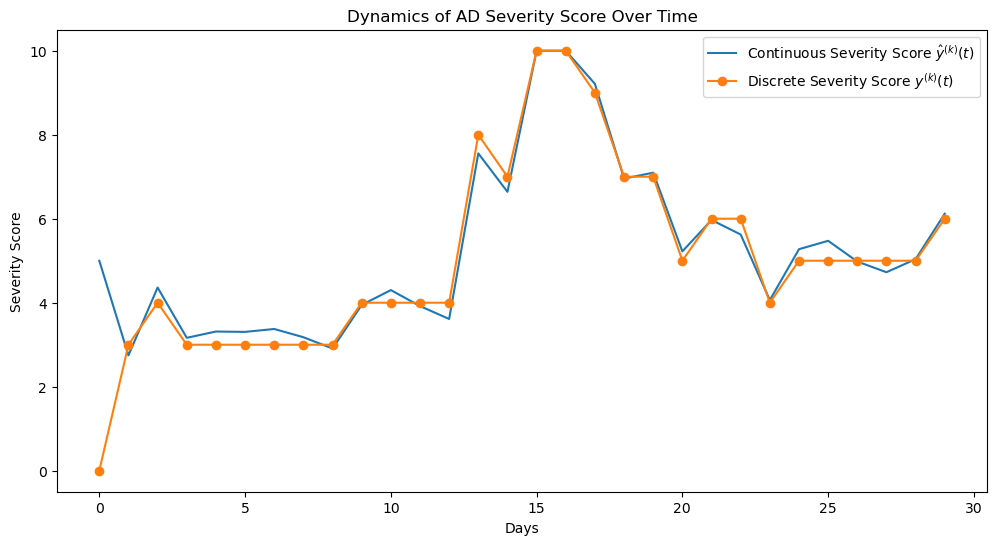

In [5]:
# Simulation settings
days = 30  # Number of days to simulate
y_hat_k_t = np.zeros(days)  # Continuous severity scores
y_k_t = np.zeros(days)      # Rounded severity scores
u_k_t = np.random.choice([0, 1], size=days)  # Treatment: 0 (none) or 1 (applied)

# Initial severity score (starting condition)
y_hat_k_t[0] = 5.0

# Fixed parameters
beta_0 = 0.2  # Population level intercept
sigma = 0.5   # Standard deviation of Gaussian noise

# Simulate the dynamics over time
for t in range(1, days):
    y_hat_k_t[t] = simulate_day(y_hat_k_t[t-1], sampled_alpha_k, sampled_theta_k, sampled_P_k, u_k_t[t-1], beta_0, sigma)
    
    # Round the continuous severity score to get the discrete severity score
    y_k_t[t] = round(y_hat_k_t[t])

# Plotting the dynamics
plt.figure(figsize=(12, 6))
plt.plot(range(days), y_hat_k_t, label='Continuous Severity Score $\hat{y}^{(k)}(t)$')
plt.plot(range(days), y_k_t, label='Discrete Severity Score $y^{(k)}(t)$', marker='o')
plt.xlabel('Days')
plt.ylabel('Severity Score')
plt.title('Dynamics of AD Severity Score Over Time')
plt.legend()
plt.show()

# Extended Mechanistic Bayesian Model

We extended our mechanistic Bayesian model to consider additional information available in the SWET dataset, which was not in the Flares dataset. This extension allows us to investigate the effects of potential risk factors on severity scores and heterogeneity in treatment responsiveness.

The extended model consists of the measurement process (Eq. (4.1)) and an exponentially modified Gaussian distribution:

$$
\hat{y}^{(k)}(t + 1) \sim \mathcal{N}_{[0,10]} \left( \alpha^{(k)} \hat{y}^{(k)}(t) + (\theta^{(k)})^T u^{(k)}(t) + (x^{(k)})^T \beta + R^{(k)}(t) + \beta_0, \sigma^2 \right)
$$

where 

$$
R^{(k)}(t) \sim \text{Exp}(\beta = P^{(k)})
$$

models the flare effect as an exponential random variable with rate $ P^{(k)} $.

## Model Components

1. **$ (\theta^{(k)})^T u^{(k)}(t) $**: Represents the contribution of exogenous factors, including treatments and whether the patient “slept at home” $ u^{(k)}_{\text{Home}}(t) $.

   - **Exogenous Factors:**
     - $$ \theta^{(k)} = \left( \theta^{(k)}_{\text{SU}}, \theta^{(k)}_{\text{CS}}, \theta^{(k)}_{\text{CI}}, \theta_{\text{Home}} \right)^T $$
     - $$ u^{(k)}(t) = \left( u^{(k)}_{\text{SU}}(t), u^{(k)}_{\text{CS}}(t), u^{(k)}_{\text{CI}}(t), u^{(k)}_{\text{Home}}(t) \right)^T $$

   - **Treatment Contributions** correspond to the linear combination of treatment usage for step-up (SU), topical steroids (CS), and calcineurin inhibitors (CI).

2. **$ (x^{(k)})^T \beta $**: Represents the contribution of demographic factors, including the presence of a filaggrin mutation, sex, age, and “white” ethnicity.
   
   - **Demographic Factors:**
     - $$ x^{(k)} = \left( x^{(k)}_{\text{FLG}}, x^{(k)}_{\text{Sex}}, x^{(k)}_{\text{Age}}, x^{(k)}_{\text{White}} \right)^T $$
     - $$ \beta = \left( \beta_{\text{FLG}}, \beta_{\text{Sex}}, \beta_{\text{Age}}, \beta_{\text{White}} \right)^T $$

3. **Hierarchical Priors:**

   - $$ \theta^{(k)}_{\text{SU}} \sim \mathcal{N}(\mu_{\text{SU}}, \sigma^2_{\text{SU}}) $$
   - For treatment $ T \in \{\text{CS, CI}\} $ and potency $ P \in \{\text{Mild, Moderate, Potent, Very Potent}\} $:
     
     $$
     \theta^{(k)}_T = \gamma^{(k)}_T + \sum_P \theta_{T, P} \hat{q}^{(k)}_{T, P}
     $$

     - $ \hat{q}^{(k)}_{T, P} $: Daily quantity of treatment $ T $ of potency $ P $ used.
     - $ \theta_{T, P} $: Relative contribution of treatment $ T $ of potency $ P $ to the severity score
     - $ \gamma^{(k)}_T \sim \mathcal{N}(\mu_T, \sigma^2_T) $: Intrinsic responsiveness of patient $k$ to treatment $T$.

4. **Daily Quantity Estimation:**

   The daily quantity of treatment used by patient $ k $, $ \hat{q}^{(k)}_{T, P} $, is estimated from the reported total quantity of treatment used, $ Q^{(k)}_{T, P} $:
   
   $$
   \hat{q}^{(k)}_{T, P} = 
   \begin{cases}
       0 & \text{if } Q^{(k)}_{T, P} = 0 \\
       \frac{Q^{(k)}_{T, P}}{N^{(k)}_{T, P}} & \text{otherwise}
   \end{cases}
   $$

   where $ N^{(k)}_{T, P} $ is the number of treatment applications and $ Q^{(k)}_{T, P} $ is estimated by a multiplicative error model:

   $$
   \log(\hat{Q}^{(k)}_{T, P}) \sim \mathcal{N} \left(\log(Q^{(k)}_{T, P}), \sigma^2_Q \cdot \text{Conf}^{(k)} \right)
   $$

   Here, $ Q^{(k)}_{T, P} $ is reported by patient $ k $ with a confidence level $ \text{Conf}^{(k)} \in \{1 = \text{“not sure”}, 2 = \text{“somewhat sure”}, 3 = \text{“sure”}, 4 = \text{“very sure”}\} $.

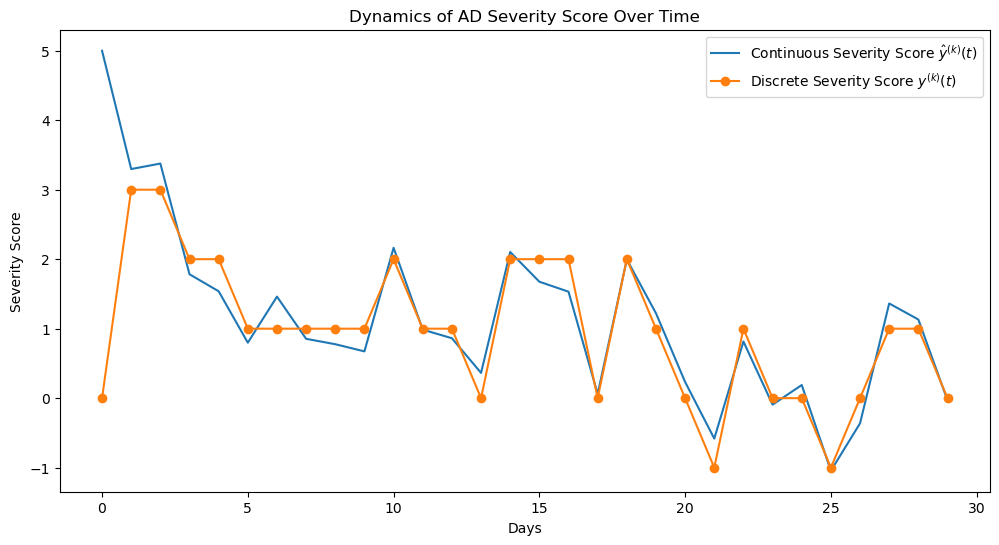

In [ ]:
# Parameters for the extended model
mu_alpha, sigma_alpha = 0.5, 0.1
mu_theta, sigma_theta = 0.5, 0.1
mu_P, sigma_P = 1.0, 0.2
beta_demographics = np.array([0.2, 0.3, -0.1, 0.5])  # example demographics contribution
mu_SU, sigma_SU = 0.5, 0.1
sigma_Q = 0.1  # multiplicative error variance for quantity
beta_0 = 0.2   # Population level intercept
sigma = 0.5    # Standard deviation of Gaussian noise

# Sample patient-specific parameters
def sample_patient_params():
    u = norm.rvs(loc=mu_alpha, scale=sigma_alpha)
    alpha_k = 1 / (1 + np.exp(-u))
    theta_k = norm.rvs(loc=mu_theta, scale=sigma_theta, size=4)  # Vector of theta parameters for treatments
    P_k = truncnorm.rvs(a=0, b=np.inf, loc=mu_P, scale=sigma_P)
    return alpha_k, theta_k, P_k

# Dynamics model
def model_dynamics(alpha_k, theta_k, P_k, y_prev, treatment_vector, demographics_vector):
    flare_effect = expon.rvs(scale=1 / P_k)
    treatment_contribution = np.dot(theta_k, treatment_vector)
    demographics_contribution = np.dot(beta_demographics, demographics_vector)
    noise = norm.rvs(loc=0, scale=sigma)
    return alpha_k * y_prev + treatment_contribution + demographics_contribution + flare_effect + beta_0 + noise

# Simulation function for a single day
def simulate_day(y_prev, alpha_k, theta_k, P_k, treatment_applied, demographics_vector):
    treatment_vector = np.array([treatment_applied, 0.5, 0.3, 1])  # example treatments vector with treatment applied
    return model_dynamics(alpha_k, theta_k, P_k, y_prev, treatment_vector, demographics_vector)

# Simulation settings
days = 30  # Number of days to simulate
y_hat_k_t = np.zeros(days)  # Continuous severity scores
y_k_t = np.zeros(days)      # Rounded severity scores
u_k_t = np.random.choice([0, 1], size=days)  # Treatment: 0 (none) or 1 (applied)

# Initial severity score (starting condition)
y_hat_k_t[0] = 5.0

# Sample patient-specific parameters
alpha_k, theta_k, P_k = sample_patient_params()
demographics_vector = np.array([1, 0, 25, 1])  # example demographics for a patient 

# Simulate the dynamics over time
for t in range(1, days):
    y_hat_k_t[t] = simulate_day(y_hat_k_t[t-1], alpha_k, theta_k, P_k, u_k_t[t-1], demographics_vector)
    # Round the continuous severity score to get the discrete severity score
    y_k_t[t] = round(y_hat_k_t[t])

# Plotting the dynamics
plt.figure(figsize=(12, 6))
plt.plot(range(days), y_hat_k_t, label=r'Continuous Severity Score $\hat{y}^{(k)}(t)$')
plt.plot(range(days), y_k_t, label=r'Discrete Severity Score $y^{(k)}(t)$', marker='o')
plt.xlabel('Days')
plt.ylabel('Severity Score')
plt.title('Dynamics of AD Severity Score Over Time')
plt.legend()
plt.show()
